In [1]:
# This notebook implements an autoencoder with convolutional layers for both
# encoder and the decoder and trains it for denoising images in MNIST data set.

# https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import collections
import datetime
import json
import math
import random
import time

import cv2
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

fsize=(20.0, 15.0)
linewidth = 1.0
dotsize = 15

Using TensorFlow backend.


### Build the autoencoder

In [3]:
input_img = keras.layers.Input(shape=(28, 28, 1))
encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

autoencoder = keras.models.Model(input_img, decoded)

encoder = keras.models.Model(input_img, encoded)

encoded_input = keras.layers.Input(shape=(7, 7, 32))
decoder_layer_1 = autoencoder.layers[-5]
decoder_layer_2 = autoencoder.layers[-4]
decoder_layer_3 = autoencoder.layers[-3]
decoder_layer_4 = autoencoder.layers[-2]
decoder_layer_5 = autoencoder.layers[-1]
decoder = keras.models.Model(encoded_input, 
                                 decoder_layer_5(
                                     decoder_layer_4(
                                         decoder_layer_3(
                                             decoder_layer_2(
                                                 decoder_layer_1(encoded_input))))))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_

### Prepare the data

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Training

In [6]:
n_epochs = 100

hist = autoencoder.fit(
            x_train,
            x_train,
            epochs=n_epochs,
            callbacks=[keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.005,
                            patience=10,
                            verbose=0,
                            mode='min')],
            batch_size=128,
            shuffle=True,
            validation_data=(x_test_noisy, x_test),
            verbose=0)

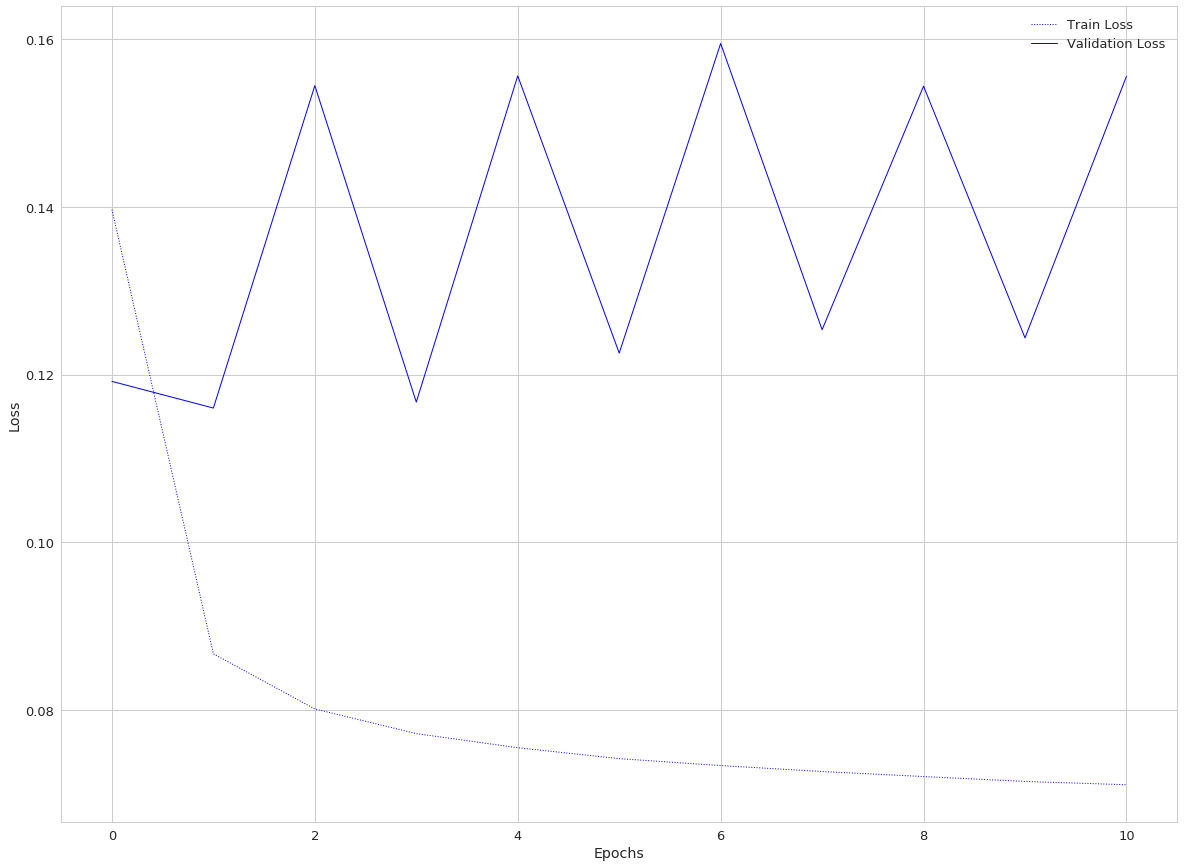

In [7]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

n_eps = range(len(loss))

_ = plt.figure(figsize=fsize)

_ = plt.plot(n_eps, loss, 'b:', label='Train Loss', linewidth=linewidth)
_ = plt.plot(n_eps, val_loss, 'b-', label='Validation Loss', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')

_ = plt.legend()

### Visualize the results

In [8]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

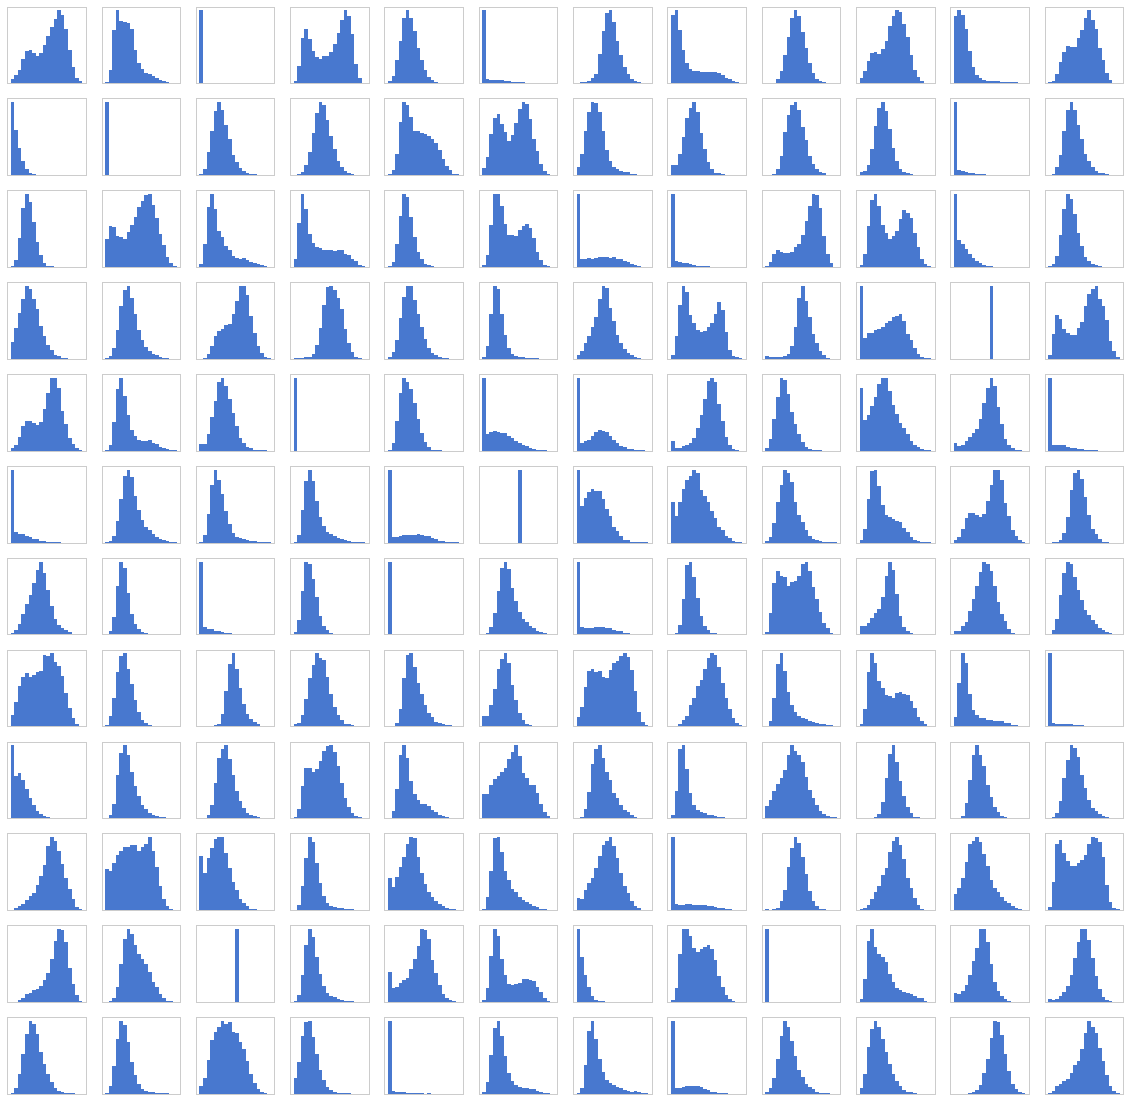

In [9]:
_ = plt.figure(figsize=(20, 20))

for i in range(144):
    a = random.randint(0, 6)
    b = random.randint(0, 6)
    c = random.randint(0, 31)
    ax = plt.subplot(12, 12, i + 1)
    plt.hist(encoded_imgs[:, a, b, c], bins=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [10]:
def display_results(input_imgs, noisy_input_imgs, output_imgs, n_results, offset):
    _ = plt.figure(figsize=(20, int(60./n_results)))
    for i in range(n_results):
        ax = plt.subplot(3, n_results, i + 1)
        plt.imshow(input_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n_results, i + 1 + n_results)
        plt.imshow(noisy_input_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n_results, i + 1 + 2*n_results)
        plt.imshow(output_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

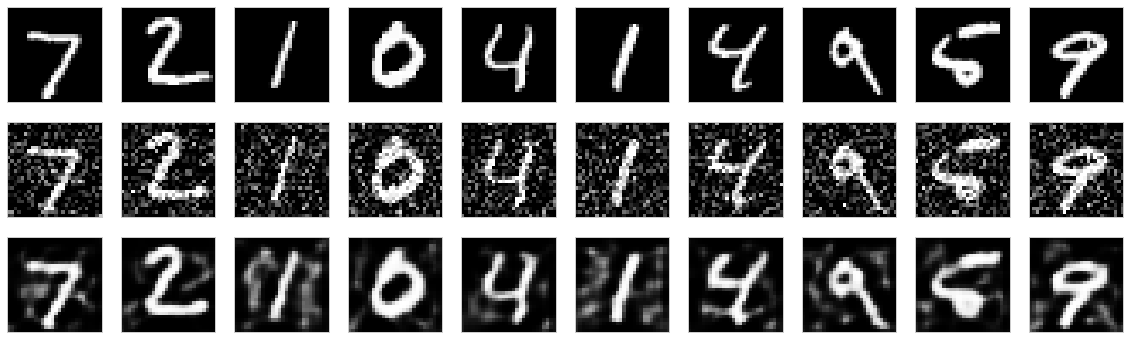

In [11]:
display_results(x_test, x_test_noisy, decoded_imgs, 10, 0)

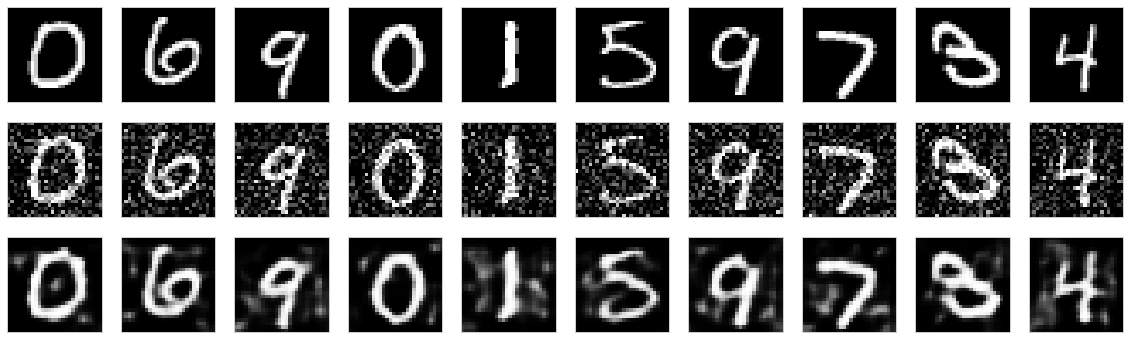

In [12]:
display_results(x_test, x_test_noisy, decoded_imgs, 10, 10)

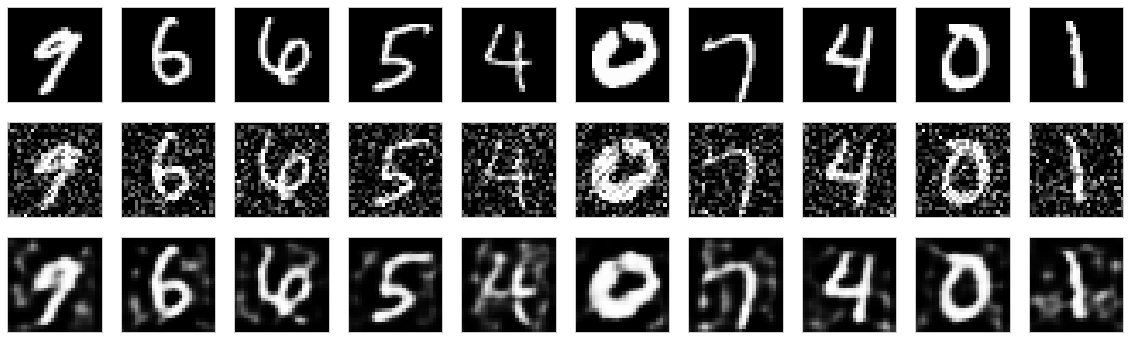

In [13]:
display_results(x_test, x_test_noisy, decoded_imgs, 10, 20)

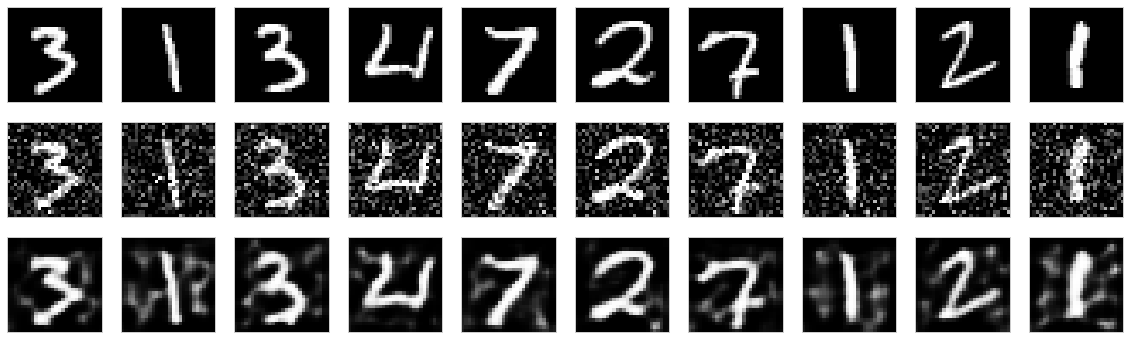

In [14]:
display_results(x_test, x_test_noisy, decoded_imgs, 10, 30)

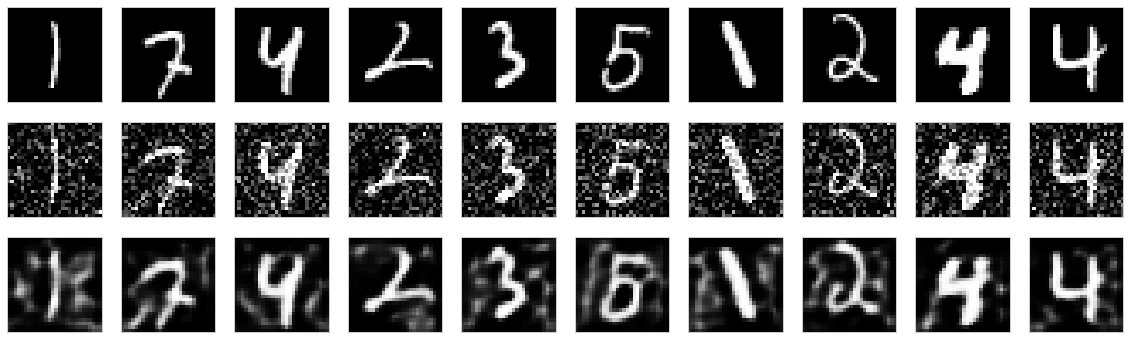

In [15]:
display_results(x_test, x_test_noisy, decoded_imgs, 10, 40)

### Let's see how it does on different types of images

In [16]:
novel_imgs = np.array([(cv2.imread('../data/ae_0{}.png'.format(i))[:,:,0]).reshape(28, 28, 1)/255. for i in range(10)])
noisy_novel_imgs = novel_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=novel_imgs.shape)
encoded_novel_imgs = encoder.predict(noisy_novel_imgs)
decoded_novel_imgs = decoder.predict(encoded_novel_imgs)

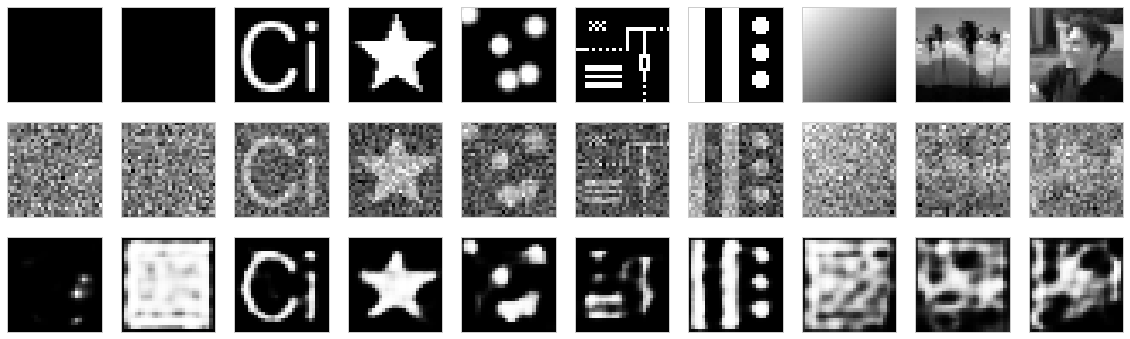

In [17]:
display_results(novel_imgs, noisy_novel_imgs, decoded_novel_imgs, 10, 0)